In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!git clone https://github.com/Florisbruinsma/GoGame

Cloning into 'GoGame'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 206 (delta 109), reused 105 (delta 13), pack-reused 0
Receiving objects: 100% (206/206), 3.78 MiB | 26.53 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

from GoGame.GoGame import GoGame
from GoGame.Model import Model
from GoGame.Agent import A2CAgent

# import gym
%load_ext tensorboard
from tensorflow.keras import backend
from tensorflow.keras import callbacks
import os
import time
import numpy as np
# %tensorboard — logdir logs

from tensorflow.python.client import device_lib

TensorFlow 2.x selected.
2.0.0
True


In [0]:
BOARDSIZE = 5
MAXTURNS = (BOARDSIZE*BOARDSIZE)-BOARDSIZE

model_name = 'goGameV2Size'+str(BOARDSIZE)
path = "/content/drive/My Drive/colab/saved_model_data/"
save_path = path + "{}.h5".format(model_name)
log_dir = path + "/logs"
log_file = log_dir + '/{}_log.txt'.format(model_name)

In [0]:
tensorboard_callback = callbacks.TensorBoard(log_dir, histogram_freq=1,write_images=True,write_grads=True,write_graph=True,update_freq='batch')
callbacks = [tensorboard_callback]
callbacks = None

In [0]:
# %tensorboard --logdir "/content/drive/My Drive/colab/saved_model_data/logs/train"

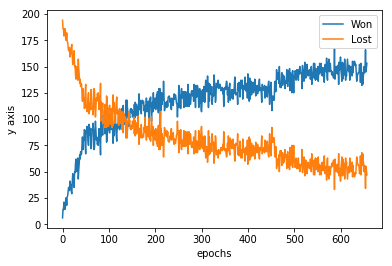

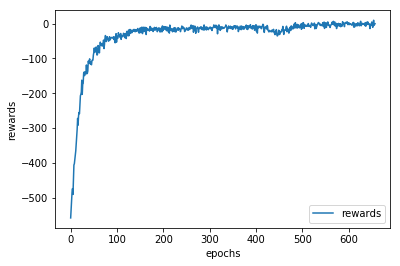

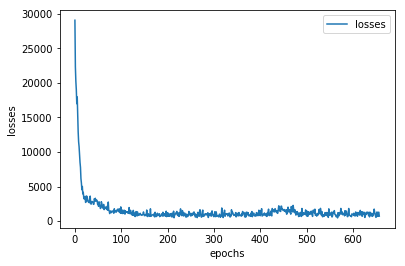

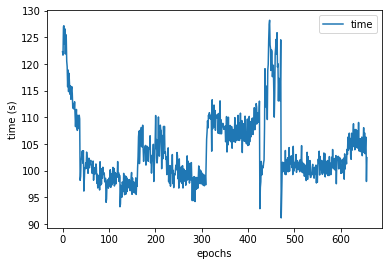

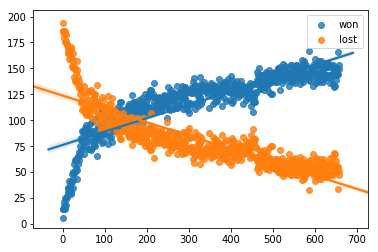

In [0]:
import matplotlib.pyplot as plt
import csv

epochs = []
won = []
lost = []
rewards = []
losses = []
time_val = []
with open(log_file, 'r') as csvFile:
    reader = csv.reader(csvFile)
    first_row = True
    for row in reader:
        if(not first_row):
            epochs.append(  int(row[0]))
            won.append(     int(row[1]))
            lost.append(    int(row[2])-int(row[1]))
            rewards.append( float(row[3]))
            losses.append(  float(row[4]))
            time_val.append(float(row[5]))
        else:
            first_row = False


plt.plot(epochs, won, label="Won")
plt.plot(epochs, lost, label="Lost")
plt.plot()

plt.xlabel("epochs")
plt.ylabel("y axis")
plt.legend()
plt.show()
#--------------------------------------------
plt.plot(epochs, rewards, label="rewards")

plt.xlabel("epochs")
plt.ylabel("rewards")
plt.legend()
plt.show()
#--------------------------------------------
plt.plot(epochs, losses, label="losses")

plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()
plt.show()
#--------------------------------------------
plt.plot(epochs, time_val, label="time")

plt.xlabel("epochs")
plt.ylabel("time (s)")
plt.legend()
plt.show()
#--------------------------------------------
import seaborn as sns
sns.regplot(epochs, won, label="won")
sns.regplot(epochs, lost, label="lost")
plt.legend()
plt.show()

In [0]:
START_EPOCH = epochs[-1] +1
EPOCHS = 500
EPISODES = 200
LEARNINGRATE = 0.0001

In [0]:
env = GoGame(BOARDSIZE, maxTurns=MAXTURNS)

model = Model(num_actions=env.action_space.n, callbacks=callbacks)
agent = A2CAgent(model,lr=LEARNINGRATE)
agent.test(env,render=False)

if(os.path.isfile(save_path)):
    model.load_weights(save_path)
    print("model loaded")
else:
    print("new model")

if(not os.path.isfile(log_file)):
    print("making new log file")
    with open(log_file, "w") as f:
        f.write("Epochs,Won,Lost,Rewards,Losses,Time\n")
# model.action_value(env.reset()[None, :])#build the model
model.summary()

for epoch in range(START_EPOCH,START_EPOCH + EPOCHS):
    time_start = time.time()
    backend.clear_session()
    rewards_history, episode_wins, losses = agent.train(env,max_steps=MAXTURNS,episodes=EPISODES, info=False, info_step=50)
    print("epoch = {:2} | won {:3}/{:3} matches | mean rewards = {:7.2f} | mean losses = {:7.2f} | epoch time = {:6.2f} sec".format(epoch, episode_wins.count(1), len(episode_wins), np.mean(rewards_history), np.mean(losses), (time.time()-time_start)))
    model.save_weights(save_path)
    print("model saved")
    with open(log_file, "a") as f:
        f.write("{:2},{:3},{:3},{:7.2f},{:7.2f},{:6.2f}\n".format(epoch, episode_wins.count(1), len(episode_wins), np.mean(rewards_history), np.mean(losses), (time.time()-time_start)))

# print("Finished training, testing...")
# for _ in range(5):
#     print("total score = %d " % agent.test(env,render=True))

model loaded
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  13312     
_________________________________________________________________
dense_1 (Dense)              multiple                  13312     
_________________________________________________________________
value (Dense)                multiple                  513       
_________________________________________________________________
policy_logits (Dense)        multiple                  12825     
_________________________________________________________________
probability_distribution (Pr multiple                  0         
Total params: 39,962
Trainable params: 39,962
Non-trainable params: 0
_________________________________________________________________
epoch = 658 | won 143/200 matches | mean rewards =   -0.35 | mean losses =  945.36 | epoch time =  92.96 sec
m